---
## **PROJET TAL** : Classification d'opinion de revues de films
#### **Auteurs** : Matéo PETITET, Mélodie FLEURY 
#### **Matière** : UE TAL - Vincent GUIGUE - 3A IODAA AgroParisTech
#### **Date de rendue** : 10 février 2025

### Objectifs
Le but de se projet est d'utiliser des commentaires de films, en anglais, issus de l'Internet Movie Database (IMDb), une base de données en ligne dédiée à l'audiovisuel. Ces commentaires sont soit positifs soit négatif par rapport au film dont ils parlent ; l'objectif est de déterminer, par différentes méthodes d'apprentissage machine, si la revue analysée est positive ou négative.

### Initialisation

In [6]:
#Imports des bibliothèques nécessaires

import gc
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import ollama
import optuna
import os
import random
import re
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence

In [2]:
#Configuration des devices : permet d'accélérer matériellement les calculs sous cuda ou apple silicon
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

#Fixation de la graine aléatoire pour la reproductibilité des résultats
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
sampler = optuna.samplers.TPESampler(seed=seed)

#Localisation des données utiles
DATASET_PATH_TRAIN = Path("data/aclImdb/aclImdb/train")
DATASET_PATH_TEST = Path("data/aclImdb/aclImdb/test")

In [2]:
#Paramètres

global_result=[]
global_methode=[]
NB_DOC_MAX = 1000 # par classe
IMDB_CLASSES  = ['neg','pos']
VOC_SIZE = 10000
BATCH_SIZE = 32
MAX_CHAR_SIZE = 1000

labels = dict(zip(IMDB_CLASSES,[0,1]))

In [4]:
#Chargement des données

def load_data(datapath, classes, max_size=None):
    txts = []
    files = []
    filelabels = []
    for label in classes:
        c = 0
        new = [os.path.join(datapath / label, f) for f in os.listdir(datapath / label) if f.endswith(".txt")]
        files += new
        # filelabels += [labels[label]] * len(new) 
        for file in (datapath / label).glob("*.txt"):
            t = file.read_text(encoding='utf8')
            txts.append(t if len(t)<MAX_CHAR_SIZE else t[:MAX_CHAR_SIZE])
            filelabels.append(labels[label])
            c+=1
            if max_size !=None and c>=max_size: break

    return txts, files, filelabels

txts, files, filelabels = load_data(DATASET_PATH_TRAIN, IMDB_CLASSES, max_size = NB_DOC_MAX)
txts_test, files_test, filelabels_test = load_data(DATASET_PATH_TEST, IMDB_CLASSES, max_size = NB_DOC_MAX)

### Première approche : apprentissage machine simple
Effectuons une première classification naïve avec 3 régresseurs standards. Cela nous permettra d'établir une performance de base.

In [5]:
# Préparation des données pour les classificateurs : pas de prétraitement
classes = filelabels
corpus = txts

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X, classes)

# Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
lr_clf.fit(X, classes)

# Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
svm_clf.fit(X, classes)

# Préparation des données de test
true = filelabels_test
test_corpus = txts_test
X_test = vectorizer.transform(test_corpus)

# Prédictions
pred_nb = nb_clf.predict(X_test)
global_result.append(accuracy_score(true, pred_nb)*100)
global_methode.append('Naïve Bayes')
pred_lr = lr_clf.predict(X_test)
global_result.append(accuracy_score(true, pred_lr)*100)
global_methode.append('Logistic Regression')
pred_svm = svm_clf.predict(X_test)
global_result.append(accuracy_score(true, pred_svm)*100)
global_methode.append('SVM accuracy')

# Évaluation
print(f"Naïve Bayes accuracy: {accuracy_score(true, pred_nb)*100}%")
print(f"Logistic Regression accuracy: {accuracy_score(true, pred_lr)*100}%")
print(f"SVM accuracy: {accuracy_score(true, pred_svm)*100}%")

Naïve Bayes accuracy: 81.2%
Logistic Regression accuracy: 78.60000000000001%
SVM accuracy: 78.10000000000001%


C:\Users\Mateo\AppData\Local\miniconda3\envs\version_vguigue\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Ces scores nous donnent une première base de performances. Nous pouvons voir que nous avons dores et déjà des performances d'accuracy très bonnes à l'aide d'un <b>classifieur Bayésien naïf</b>.

### L'approche "Sac de Mots"

L'approche <b>"Sac de Mots"</b> ("Bag of Words", BoW) consiste en la représentation d'un texte par un vecteur de la même taille que le vocabulaire du texte. Cette approche est simpliste et ne prend pas en compte le contexte, mais peut permettre d'obtenir tout de même des résultats intéressants.

In [6]:
# Méthode Bag of Words
X_train = vectorizer.fit_transform(txts).toarray()
X_test = vectorizer.transform(txts_test).toarray()
vocab_size = X_train.shape[1]

# Conversion des labels en tenseurs PyTorch
y_train = torch.tensor(filelabels, dtype=torch.long)
y_test = torch.tensor(filelabels_test, dtype=torch.long)

# Conversion des données en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Définition du modèle
class BoWClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(BoWClassifier, self).__init__()
        self.fc = nn.Linear(vocab_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Initialisation du modèle
num_classes = 2  # Positif ou négatif
model = BoWClassifier(vocab_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [7]:
# Entraînement et performances

# Liste pour stocker les valeurs de loss et accuracy
train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward
    loss.backward()
    optimizer.step()

    # Évaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_loss = criterion(outputs, y_test).item()
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    train_losses.append(loss.item())
    test_losses.append(test_loss)
    test_accuracies.append(accuracy*100)

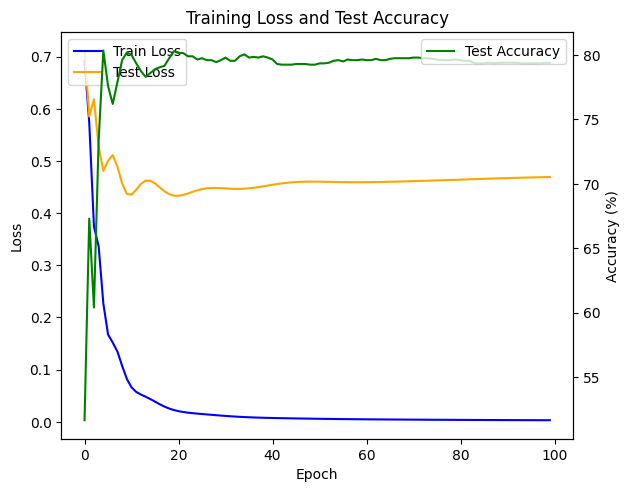

Meilleure accuracy :  80.35 %


In [8]:
# Tracé des courbes
fig, ax1 = plt.subplots()

# Courbe de la loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(test_losses, label='Test Loss', color='orange')
ax1.tick_params(axis='y')

# Courbe de l'accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)')
ax2.plot(test_accuracies, label='Test Accuracy', color='green')
ax2.tick_params(axis='y')

# Légende et affichage
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Training Loss and Test Accuracy')
plt.show()

print('Meilleure accuracy : ', max(test_accuracies), '%')
global_result.append(max(test_accuracies))
global_methode.append('Bag of Words')

![Training Loss et Test Accuracy](images/bow.png)
Nous pouvons constater que la meilleure accuracy atteinte, bien que relativement bonne, n'égale pas celle du classifieur Bayésien naïf. De plus, nous observons la chute des performance avec le nombre d'epochs de 'entraînement ; un sur-apprentissage a lieu.

L'un des inconvénient du BoW est qu'il va, par défaut, distinguer des mots selon leurs majuscules, accents... Et ainsi mener à une taille de vocabulaire bien plus importante et une perte de performance. Pour éviter cela, nous allons appliquer différents prétraitements :
- conversion intégrale du texte en minuscule
- suppression des nombres (ici peut utiles a priori)
- suppression des ponctuations (sans utiliser le contexte elles sont également inutiles)
- utilisation de "stopwords", mots volontairement ignorés ; une liste est directement importée
- lemmatisation, ramener les mots à leur forme de base
- tokenisation

Toutes ces procédures permettent de simplifier grandement le vocabulaire de représentation et possiblement d'améliorer les performances.

In [9]:
#Prétraitement

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_text(text):
    # Conversion en minuscules
    text = text.lower()

    # Suppression des nombres
    text = re.sub(r'\d+', '', text)

    # Suppression des ponctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoindre les tokens en une chaîne
    text = ' '.join(tokens)

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


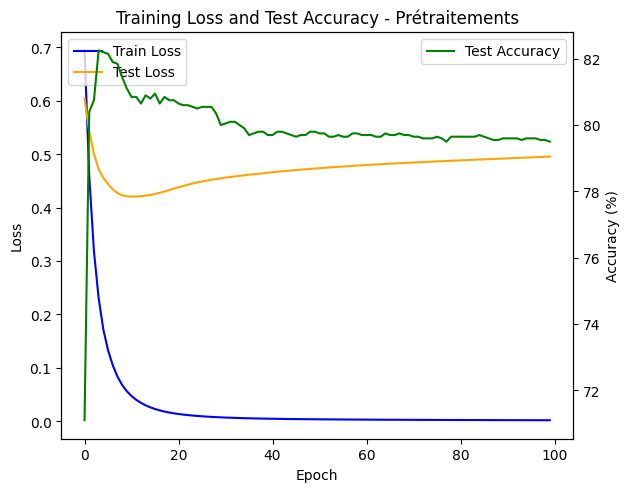

Meilleure accuracy :  82.25 %


In [10]:
# Chargement des données avec prétraitement
def load_data(datapath, classes, max_size=None):
    txts = []
    files = []
    filelabels = []
    for label in classes:
        c = 0
        new = [os.path.join(datapath / label, f) for f in os.listdir(datapath / label) if f.endswith(".txt")]
        files += new
        for file in (datapath / label).glob("*.txt"):
            t = file.read_text(encoding='utf8')
            t = preprocess_text(t)  # Appliquer le prétraitement
            txts.append(t if len(t) < MAX_CHAR_SIZE else t[:MAX_CHAR_SIZE])
            filelabels.append(labels[label])
            c += 1
            if max_size is not None and c >= max_size:
                break
    return txts, files, filelabels

# Chargement des données
txts, files, filelabels = load_data(DATASET_PATH_TRAIN, IMDB_CLASSES, max_size=NB_DOC_MAX)
txts_test, files_test, filelabels_test = load_data(DATASET_PATH_TEST, IMDB_CLASSES, max_size=NB_DOC_MAX)

# Méthode Bag of Words
X_train = vectorizer.fit_transform(txts).toarray()
X_test = vectorizer.transform(txts_test).toarray()
vocab_size = X_train.shape[1]

# Conversion des labels en tenseurs PyTorch
y_train = torch.tensor(filelabels, dtype=torch.long)
y_test = torch.tensor(filelabels_test, dtype=torch.long)

# Conversion des données en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Définition du modèle
class BoWClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(BoWClassifier, self).__init__()
        self.fc = nn.Linear(vocab_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Initialisation du modèle
num_classes = 2  # Positif ou négatif
model = BoWClassifier(vocab_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entraînement et performances
# Liste pour stocker les valeurs de loss et accuracy
train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward
    loss.backward()
    optimizer.step()

    # Évaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_loss = criterion(outputs, y_test).item()
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    train_losses.append(loss.item())
    test_losses.append(test_loss)
    test_accuracies.append(accuracy*100)

# Tracé des courbes
fig, ax1 = plt.subplots()

# Courbe de la loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(test_losses, label='Test Loss', color='orange')
ax1.tick_params(axis='y')

# Courbe de l'accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)')
ax2.plot(test_accuracies, label='Test Accuracy', color='green')
ax2.tick_params(axis='y')

# Légende et affichage
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Training Loss and Test Accuracy - Prétraitements')
plt.show()

print('Meilleure accuracy : ', max(test_accuracies), '%')

global_result.append(max(test_accuracies))
global_methode.append('Bag of Words - Prétraitements')

![Training Loss et Test Accuracy - Prétraitement](images/bow-pt.png)
Les performances s'améliorent ici par rapport au BoW brut, et parviennent même à dépasser celles du classifieur Bayésien naïf. Toutefois, cette deuxième "victoire" n'est, contrairement à la première, pas systématique.

Afin d'améliorer encore les performances de cette approche, nous pouvons lancer une campagne de recherche des meilleurs hyperparamètres. Avec notre fonction BoW simple, nous pouvons jouer sur :
- le taux d'apprentissage
- la taille du batch
- le nombre d'epochs
- la taille des n-grammes

Les n-grammes correspondent à la taille des sacs de mots considérés. Un "mot" de vocabulaire peut être ainsi constitué de deux mots réels, et donner une forme de contexte. Dans notre cas, si un commentaire négatif contient "not good", une aproche uniquement par unigrammes pourra interpréter la présence du "good" comme signe d'un commentaire positif, alors qu'une approche bigramme considèrera le "not good" entier et tendra plus vers une classification en négatif.

Afin de mener cette campagne d'optimisation, nous utilisons Optuna, très performant.

In [11]:
# Fonction d'objectif pour Optuna
def objective(trial):
    # Suggestion des hyperparamètres
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 10, 100)
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)])

    # Initialisation du modèle et de l'optimiseur
    model = BoWClassifier(vocab_size, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # DataLoader avec la taille de batch spécifiée
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    # Entraînement et évaluation
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Évaluation sur l'ensemble de test
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test).item()
            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == y_test).sum().item() / y_test.size(0)

        # Report de l'accuracy à Optuna
        trial.report(accuracy, epoch)

        # Préparation pour l'early stopping
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

# Création de l'étude Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Affichage des résultats
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

global_result.append(format(trial.value)*100)
global_methode.append('Bag of Words - Prétraitements - Optimisé')

[I 2025-02-10 17:43:29,035] A new study created in memory with name: no-name-f6341196-80cb-4352-a342-12386960b919
C:\Users\Mateo\AppData\Local\Temp\ipykernel_14636\1172139119.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
C:\Users\Mateo\AppData\Local\miniconda3\envs\version_vguigue\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
C:\Users\Mateo\AppData\Local\miniconda3\envs\version_vguigue\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but

Best trial:
  Value: 0.83
  Params: 
    learning_rate: 0.0006832210867221183
    batch_size: 16
    num_epochs: 45
    ngram_range: (1, 2)


Best trial:

    Value: 0.83
  
  Params: 
  
    learning_rate: 0.0006832210867221183  
    batch_size: 16
    num_epochs: 45
    ngram_range: (1, 2)

La campagne a permis de trouver de nouveaux hyperparamètres améliorants encore la performance du BoW. Nous sommes ainsi clairement au-dessus du classifieur Bayésien naïf. Toutefois, ces approches restent dans un cadre d'apprentissage machine classique. Essayons à présent une approche en apprentissage profond.

### L'approche apprentissage profond

Nous allons utiliser une représentation des mots (embeddings) déjà fournie.

In [12]:
#Nouveau chargement des données

GLOVE_PATH = Path("data/glove/glove")
DATASET_PATH = Path("data/aclImdb/aclImdb")

class FolderText(Dataset):
    """Dataset basé sur des dossiers (un par classe) et fichiers"""

    def __init__(self, classes, folder: Path, tokenizer, train_max_size=None, load=False):
        self.tokenizer = tokenizer   #Utilisation du tokenizer importé
        self.files = []
        self.filelabels = []
        self.labels = {key: ix for ix, key in enumerate(classes)}
        
        for label in classes:
            c = 0
            for file in (folder / label).glob("*.txt"):
                self.files.append(file.read_text(encoding='utf8') if load else file)
                self.filelabels.append(self.labels[label])
                c += 1
                if train_max_size is not None and c > train_max_size:
                    break

    def __len__(self):
        return len(self.filelabels)
    
    def __getitem__(self, ix):
        s = self.files[ix]
        tokenized = torch.tensor(self.tokenizer(s if isinstance(s, str) else s.read_text()), device=device)
        label = torch.tensor(self.filelabels[ix], device=device)
        return tokenized, label

def get_imdb_data(embedding_size=50, train_max_size=None):
    """Renvoie l'ensemble des données nécessaires pour l'apprentissage 

    - dictionnaire word vers ID
    - embeddings (Glove)
    - DataSet (FolderText)

    """
    WORDS = re.compile(r"\S+")
    glove_fn = open(GLOVE_PATH / ("glove.6B.%dd.txt" % embedding_size), encoding='utf8')
    words, embeddings = [], []
    
    for line in glove_fn:
        values = line.split()
        words.append(values[0])
        embeddings.append([float(x) for x in values[1:]])

    OOVID = len(words)
    words.append("__OOV__")

    word2id = {word: ix for ix, word in enumerate(words)}
    embeddings = np.vstack((embeddings, np.zeros(embedding_size)))
    embeddings = torch.tensor(embeddings, dtype=torch.float32, device=device)

    def tokenizer(t):
        return [word2id.get(x, OOVID) for x in re.findall(WORDS, t.lower())]

    logging.info("Loading embeddings")
    logging.info("Get the IMDB dataset")
    
    return word2id, embeddings, FolderText(IMDB_CLASSES, DATASET_PATH / "train", tokenizer, train_max_size, load=True), FolderText(IMDB_CLASSES, DATASET_PATH / "test", tokenizer, train_max_size, load=True)

word2id, embeddings, train_dataset, test_dataset = get_imdb_data()

#data loader
BATCH_SIZE = 100

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], device=device)
    padded_sequences = pad_sequence(sequences, batch_first=False).to(device)
    labels = torch.tensor(labels, device=device)
    return padded_sequences, torch.tensor(lengths), torch.tensor(labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [13]:
# Définition du réseau
class RNNSent(nn.Module):
    def __init__(self, hidden_size, output_size, embeddings, device):
        super(RNNSent, self).__init__()

        self.device = device
        self.hidden_size = hidden_size
        self.input_size = len(embeddings[0])
        self.emb = nn.Embedding(len(embeddings), len(embeddings[0]))

        # INITIALISATION des embeddings
        self.emb.weight.requires_grad = False
        
        # Envoyer l'embedding layer sur le device
        self.emb.to(device)

        # CHOIX Du module récurrent
        self.rec = nn.RNN(self.input_size, self.hidden_size, nonlinearity='tanh').to(device)

        # ATTENTION
        self.attention = nn.Linear(hidden_size, 1, bias=False).to(device)
        self.h2o = nn.Linear(hidden_size, output_size).to(device)

        
    def forward(self, input, lengths=None):
        maxlen = input.size(0)
        batch_size = input.size(1)

        # Déplacement de l'entrée sur le bon device
        input = input.to(self.device)
        if lengths is not None:
            lengths = lengths.to(self.device)

        # Entrée vers embeddingts
        xemb = self.emb(input).to(self.device)

        # Passage dans le rec
        hidden, last = self.rec(xemb)   # RNN

        # Récupération des dernières couches
        if lengths is not None:
            last = torch.stack([hidden[lengths[i] - 1, i, :].to(self.device) for i in range(batch_size)])

        # Ajout de l'attention
        a = self.attention(hidden).squeeze(-1).to(self.device)

        # Mask
        mask = torch.arange(maxlen, device=self.device).unsqueeze(1).expand(maxlen, batch_size) < lengths.unsqueeze(0)
        masked_attn_scores = a.masked_fill(~mask, float('-inf'))

        # Calcul de l'attention (utilisation du softmax) + application sur les couches cachées
        a = F.softmax(masked_attn_scores, dim=0).unsqueeze(-1)

        last = torch.sum(a * hidden, dim=0)

        output = self.h2o(last).squeeze(0)
        
        return output, hidden

In [14]:
#Paramètres

# Taille de la couche cachée
n_hidden = 128
output_size = 2

# Réseau
rnn = RNNSent( n_hidden,  output_size, embeddings, device)
rnn.name = "RNNSent-"+time.asctime()

In [15]:
# Définition de la métrique d'évaluation
def accuracy(yhat,y):
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).float().mean()

In [38]:
#Boucle d'entraînement
def train(model, epochs, train_loader, test_loader):
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)  # choix optimizer
    model = model.to(device)
    print(f"running {model.name}")
    loss = nn.CrossEntropyLoss()  # choix loss

    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x, lengths, y in train_loader:  # boucle sur les batchs
            optim.zero_grad()
            x, y = x.to(device), y.to(device)  # y doit être un tenseur (pas un int)
            yhat, next_hidden = model(x, lengths)
            l = loss(yhat, y)
            l.backward()
            optim.step()
            cumloss += l * len(x)  # attention, il peut y avoir un batch + petit (le dernier)
            cumacc += accuracy(yhat, y) * len(x)
            count += len(x)
        print(epoch)
        model.eval()
        with torch.no_grad():
            cumloss, cumacc, count = 0, 0, 0
            for x, lengths, y in test_loader:
                x, y = x.to(device), y.to(device)
                yhat, next_hidden = model(x, lengths)
                cumloss += loss(yhat, y) * len(x)
                cumacc += accuracy(yhat, y) * len(x)
                count += len(x)

            # Calcul des performances de test
            test_loss = cumloss / count
            test_acc = cumacc / count
            test_losses.append(test_loss.item())
            test_accuracies.append(test_acc.item()*100)
            print(f"Epoch {epoch}: Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc*100:.4f}%")

    return model, test_losses, test_accuracies

In [41]:
n_epoch = 20
mod, test_l, test_a = train(rnn, n_epoch, train_loader, test_loader) 

running RNNSent-Mon Feb 10 17:48:07 2025


C:\Users\Mateo\AppData\Local\Temp\ipykernel_14636\172137962.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return padded_sequences, torch.tensor(lengths), torch.tensor(labels)


0
Epoch 0: Test Loss = 1.6996, Test Accuracy = 74.3279%
1
Epoch 1: Test Loss = 1.7147, Test Accuracy = 74.6559%
2
Epoch 2: Test Loss = 1.7006, Test Accuracy = 74.6976%
3
Epoch 3: Test Loss = 1.7273, Test Accuracy = 74.7003%
4
Epoch 4: Test Loss = 1.6537, Test Accuracy = 74.6145%
5
Epoch 5: Test Loss = 1.6188, Test Accuracy = 74.8982%
6
Epoch 6: Test Loss = 1.6427, Test Accuracy = 74.6871%
7
Epoch 7: Test Loss = 1.6828, Test Accuracy = 74.6488%
8
Epoch 8: Test Loss = 1.7202, Test Accuracy = 74.8098%
9
Epoch 9: Test Loss = 1.8334, Test Accuracy = 75.0466%
10
Epoch 10: Test Loss = 1.8698, Test Accuracy = 74.9507%
11
Epoch 11: Test Loss = 1.9421, Test Accuracy = 74.8415%
12
Epoch 12: Test Loss = 1.9808, Test Accuracy = 74.8127%
13
Epoch 13: Test Loss = 2.0372, Test Accuracy = 74.7985%
14
Epoch 14: Test Loss = 2.0807, Test Accuracy = 74.7971%
15
Epoch 15: Test Loss = 2.1228, Test Accuracy = 74.6821%
16
Epoch 16: Test Loss = 2.1575, Test Accuracy = 74.6680%
17
Epoch 17: Test Loss = 2.1896, T

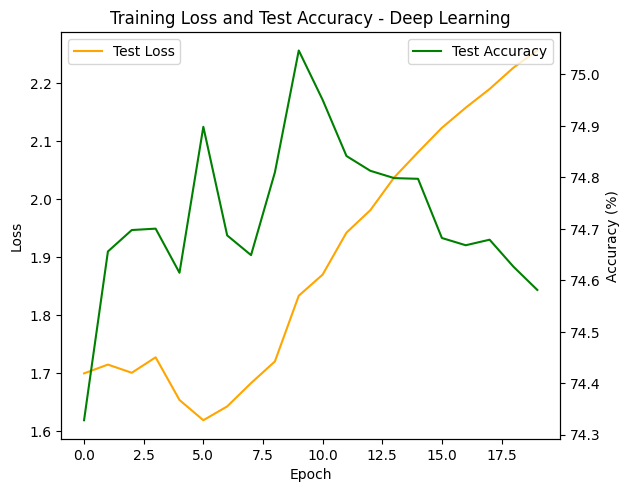

Meilleure accuracy :  75.04657506942749 %


In [42]:
# Tracé des courbes
fig, ax1 = plt.subplots()

# Courbe de la loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(test_l, label='Test Loss', color='orange')
ax1.tick_params(axis='y')

# Courbe de l'accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)')
ax2.plot(test_a, label='Test Accuracy', color='green')
ax2.tick_params(axis='y')

# Légende et affichage
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Training Loss and Test Accuracy - Deep Learning')
plt.show()

print('Meilleure accuracy : ', max(test_a), '%')

global_result.append(max(test_a))
global_methode.append('Deep Learning')

![Training Loss and Test Loss - Deep Learning](images/deep.png)

Les performances brutes sont globalement moins bonnes qu'une approche plus simple de BoW. Nous pouvons, là encore, mener avec optuna une campagne d'optimisation des hyperparamètres. Seront explorés :
- la taille de la couche cachée
- le taux d'apprentissage
- la taille de batch
- le nombre d'epoch d'apprentissage
- l'optimiseur
- une régularisation L2
- le dropout

Attention : cette campagne est <b>extrêmement longue</b> à exécuter ! Il aura fallu plus de 16 heures sur un petit gpu cuda.

In [18]:
#Libération de la mémoire
def free_up_memory():
    if device == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

# Fonction d'objectif pour Optuna
def objective(trial):
    # Suggestion des hyperparamètres
    hidden_size = trial.suggest_int('hidden_size', 32, 512)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    epochs = trial.suggest_int('epochs', 1, 15)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    dropout = trial.suggest_uniform('dropout', 0.2, 0.5)

    # Initialisation du modèle
    model = RNNSent(hidden_size, output_size, embeddings, device)
    model.name = "RNNSent-Optuna"

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # DataLoader avec la taille de batch spécifiée
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Entraînement et évaluation
    model, test_losses, test_accuracies = train(model, epochs, train_loader, test_loader)

    # Libération de la mémoire après l'entraînement
    free_up_memory()

    # Retourne la meilleure accuracy de test
    best_accuracy = max(test_accuracies)
    return best_accuracy

# Création de l'étude Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, callbacks=[lambda study, trial: free_up_memory()])

# Affichage des résultats
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

global_result.append(format(trial.value))
global_methode.append('Deep Learning - Optimisé')

[I 2025-02-10 17:59:25,655] A new study created in memory with name: no-name-317d5fc3-6dab-4ad3-a11a-3a49b5154eab
C:\Users\Mateo\AppData\Local\Temp\ipykernel_14636\2374953960.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\Mateo\AppData\Local\Temp\ipykernel_14636\2374953960.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
C:\Users\Mateo\AppData\Local\Temp\ipykernel_14636\2374953960.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna

running RNNSent-Optuna
0
Epoch 0: Test Loss = 0.6303, Test Accuracy = 0.6526


[W 2025-02-10 18:01:14,205] Trial 0 failed with parameters: {'hidden_size': 285, 'learning_rate': 0.0020819178989476004, 'batch_size': 16, 'epochs': 7, 'optimizer': 'SGD', 'weight_decay': 1.098707905298455e-06, 'dropout': 0.2130053335360682} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\Mateo\AppData\Local\miniconda3\envs\version_vguigue\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Mateo\AppData\Local\Temp\ipykernel_14636\2374953960.py", line 32, in objective
    model, test_losses, test_accuracies = train(model, epochs, train_loader, test_loader)
                                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Mateo\AppData\Local\Temp\ipykernel_14636\2006311489.py", line 17, in train
    yhat, next_hidden = model(x, lengths)
                        ^^^^^^^^^^^^^^^^^
  File "C:\

KeyboardInterrupt: 

Best trial:

    Value: 80.74683547019958
  
  Params: 
    
    hidden_size: 39
    learning_rate: 1.127222730772094e-05  
    batch_size: 32
    num_epochs: 15
    optimizer: SGD
    weigh_decay: 7.095839077194373e-05
    dropout: 0.2168193597137401

L'optimisation permet d'améliorer les performances par rapport à la version simpliste. Toutefois, nous ne dépassons pas le BoW avec prétraitement, malgrès ce à quoi l'on pourrait s'attendre. En effet, les approches deep learning sont plus récentes et donc a priori plus performantes. Cette expérience nous montre que cela n'est pas systématique


### Une approche originale : ollama et zero/few-shot

Ollama est un projet permettant d'exécuter, sur un serveur virtuel local, des modèles de TAL open-source. Il existe une bibliothèque python permettant d'extraire les réponses issues de ce serveur et les utiliser dans une fonction. Nous allons utliser cela afin de mener une campagne de classification zero-shot et few-shot. Le modèle choisi ici est qwen 2.5 en taille 0,5b, présentant le meilleur compromis taille / qualité.

#### Zero-shot
La méthode <b>zero-shot</b> consiste à donner le texte à classifier au modèle et lui demander directement son "avis" dessus. Nous lui demandons ainsi directement de mener la recherche demandée.

In [5]:
# Classification zero-shot
def classification_zero_shot(exemple):
    prompt = f"Give the sentiment of the following text in only one word: 'Positive' or 'Negative' :\n\n{exemple}"
    reponse = ollama.generate(model='qwen2.5:0.5b',prompt=prompt)
    return reponse

#### Few-shot
Comme pour le zero-shot, le <b>few-shot</b> consiste à demander directement au modèle son avis. Toutefois, nous lui donnons, dans l'instruction, des exemples préalables afin de l'aider à mieux se repérer.

In [7]:
# Classification few-shot
def classification_few_shot(exemple):
    prompt = f"These texts are in the category 'Positive': \n{txts[1500]}\n and \n{txts[1700]}.\n\nThese texts are in the category 'Negative': \n{txts[500]}\n and \n{txts[700]}.\n\n Give the sentiment of the following text in only one word: 'Positive' or 'Negative' :\n\n{exemple}"
    reponse = ollama.generate(model='qwen2.5:0.5b',prompt=prompt)
    return reponse

<b>Attention !</b> Ces deux méthodes sont très sensibes à l'instruction fournie (le prompt) ; changer l'instruction pourrait mener à de grandes différences de performances. De plus, il n'est pas possible de mettre en place une graine de génération aléatoire pour reproduire aisément les résultats. Les instructions fournies ont été déterminées à force d'essais et semble être les plus fonctionnelles. Enfin, les résultat son très dépendant du modèle utilisé ; utiliser le dernier et plus performant modèle de raisonnement comme deepseek-r1 671b donnerai assurément de meilleurs résultats, mais avec un coût calculatoire bien plus important.

#### Évaluation
Nous allons comparer la réponse du modèle avec la catégorie effective du commentaire fourni. Nous ajoutons cependant une troisième catégorie, lorsque la réponse donnée n'est pas dans le format attendu. En effet, nous voulons obtenir "Negative" ou "Positive", mais il arrive que le modèle puisse répondre "Negative.", "positive", "Positive ", "This reviexw is negative.", etc. Nous considérons ces réponses commes invalides.

In [9]:
def test_perf(dataset,methode,labels_vrais):
    # Mélange des données
    temp = list(zip(dataset, labels_vrais))
    random.shuffle(temp)
    dataset, labels_vrais = zip(*temp)
    dataset, labels_vrais = list(dataset), list(labels_vrais)
    ok,pb_rep,nul=0,0,0
    for k in range(len(dataset)):
        if (methode(dataset[k]).response =='Positive' and labels_vrais[k]==1) or (methode(dataset[k]).response=='Negative' and labels_vrais[k]==0) :
            ok+=1
        elif methode(dataset[k]).response !='Positive' and methode(dataset[k]).response!='Negative':
            pb_rep+=1
        else:
            nul+=1
    return ok, pb_rep, nul

In [14]:
# Accuracy classification zero-shot
o1,p1,n1 = test_perf(txts_test, classification_zero_shot, filelabels_test)

perc_o1 = 100*o1/(len(txts_test))
perc_p1 = 100*p1/(len(txts_test))
perc_n1 = 100*n1/(len(txts_test))

print(
    'Zero-shot\n Ok : ', perc_o1, '%\n', 
    'Nuls : ', perc_n1, '%\n', 
    'Mauvais format de réponse : ', perc_p1, '%.')

global_result.append(perc_o1)
global_methode.append('Ollama - zero-shot')

# Accuracy classification few-shot
o2,p2,n2 = test_perf(txts_test, classification_few_shot, filelabels_test)

perc_o2 = 100*o2/(len(txts_test))
perc_p2 = 100*p2/(len(txts_test))
perc_n2 = 100*n2/(len(txts_test))

print(
    'Few-shot\n Ok : ', perc_o2, '%\n', 
    'Nuls : ', perc_n2, '%\n', 
    'Mauvais format de réponse : ', perc_p2, '%.')

global_result.append(perc_o2)
global_methode.append('Ollama - few-shot')

Zero-shot
 ok :  85.5 % Nuls :  12.85 % Mauvais format de réponse :  1.65 %.
Few-shot
 ok :  78.5 % nuls :  16.95 % Mauvais format de réponse :  4.55 %.


In [8]:
perc_o1=82.5
perc_o2=78.5
perc_n1=12.85
perc_n2=16.95
perc_p1=1.65
perc_p2=4.55

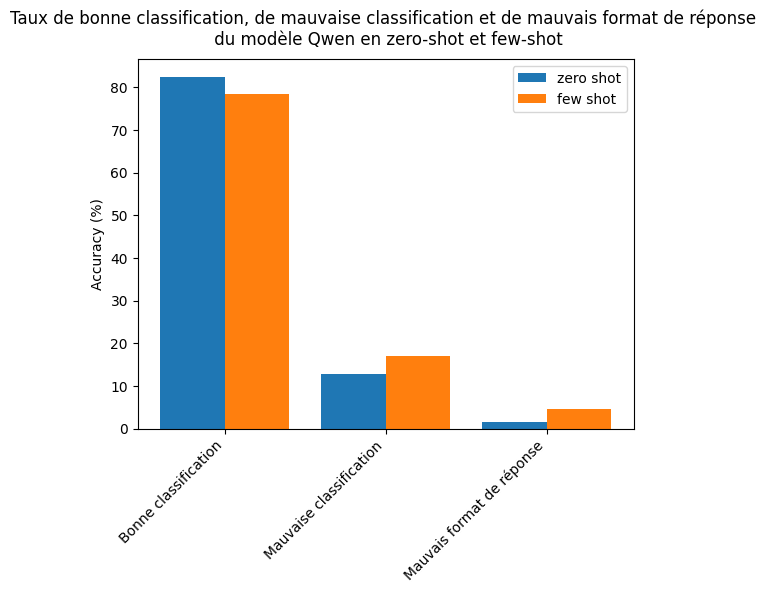

In [9]:
# Visualisation des résultats
fig, ax = plt.subplots()

X = ['Bonne classification', 'Mauvaise classification', 'Mauvais format de réponse']

zero_shot = [perc_o1, perc_n1, perc_p1]
few_shot = [perc_o2, perc_n2, perc_p2]

X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, zero_shot, 0.4, label = 'zero shot') 
plt.bar(X_axis + 0.2, few_shot, 0.4, label = 'few shot') 

# Rotation des étiquettes pour éviter le chevauchement
plt.xticks(rotation=45, ha="right")

plt.xticks(X_axis, X) 
plt.legend() 
ax.set_ylabel('Accuracy (%)')
ax.set_title("Taux de bonne classification, de mauvaise classification et de mauvais format de réponse \n du modèle Qwen en zero-shot et few-shot", pad = 10)

plt.show()

![Accuracy ollama](images/ollama1.png)
Nous pourrions instinctivement s'attendre à ce que le few-shot soit plus efficace ; or, ça n'est pas systématiquement le cas. Cependant, comme expliqué précédemment, les résultats dépendent beaucoup de l'instruction et du modèle choisi, et varie même d'un essai à l'autre.
Nous voyons également que, dans l'exemple fourni, le zero-shot nous offre les meilleures performances de tous les modèles explorés ici. Il est donc parfois plus simple de se reposer sur des modèles pré-entraînés.

### Conclusion et récapitulatif

Ce projet montre que les solutions les plus complexes ne sont pas forcément les meilleures. Le deep learning, approche la plus récente, se fait supplanter par des méthodes BoW et même de la classification Bayésienne naïve, quand bien même le TAL est une tâche où le deep learning est très performant. Il est donc important d'adapter la méthode à la complexité de la tâche : une classification binaire, comme celle-ci, ne demande pas de méthodes trop complexes.

Le prétraitement des textes est une étape très importante pour améliorer les performances.

Enfin, un modèle tout fait, même très léger (0.5 milliards de paramètres) peut supplanter toutes les approches "maison", comme nous avons pu le constater. Il va être très important de maîtriser leur usage afin de profiter de leurs capacités.

In [ ]:
# Histogramme récapitulatif

# Couleur selon la performance
valeurs_normalisees = (np.array(global_result) - min(global_result)) / (max(global_result) - min(global_result))


plt.figure(figsize=(10, 6))
plt.bar(global_methode, global_result, color=plt.cm.RdYlGn(valeurs_normalisees))

plt.title("Accuracy selon la méthode")
plt.xlabel("Méthode")
plt.ylabel("Accuracy (%)")

# Affichage des valeurs sur les barres
for i, v in enumerate(global_result):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
    
plt.xticks(rotation=45, ha="right")

plt.show()

![Résumé des performances](images/resume.png)